In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import SparseRandomProjection
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.decomposition import PCA, FastICA

from time import perf_counter

import umap

from utilities import get_reconstruction_error, get_pca_components_for_var, df_to_heatmap, get_max_along_df_axis

In [14]:
# Set n_components to be used during grid searching (was set here based on PCA)
n_components = [2, 3, 4, 5, 13, 23, 27, 30, 32, 35, 40]

In [11]:
# Import shared settings
from settings import random_state, n_jobs, nSamples, max_iter, test_size, class_sep
# Override settings
#...

In [12]:
# Used for plot names
dim_red_name = "rp"
casename = f"synthetic_{dim_red_name}"
# scoreText = "Score (Classification Accuracy)"

# Generate Data

In [13]:
X_full, y_full = make_classification(n_samples=nSamples, n_features=40, n_informative=10, n_redundant=5, n_classes=6, random_state=random_state, class_sep=class_sep)

X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=test_size, 
                                      random_state=random_state, stratify=y_full)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print("Fraction of training data for each label = ")
for label in np.unique(y):
    print(f'\tData labelled {label} = {(y == label).sum() / float(len(y))}')

print('')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
print("Fraction of testing data for each label = ")
for label in np.unique(y):
    print(f'\tData labelled {label} = {(y == label).sum() / float(len(y))}')


X.shape = (2000, 40)
y.shape = (2000,)
Fraction of training data for each label = 
	Data labelled 0 = 0.165
	Data labelled 1 = 0.169
	Data labelled 2 = 0.17
	Data labelled 3 = 0.1635
	Data labelled 4 = 0.166
	Data labelled 5 = 0.1665

X_test.shape = (500, 40)
y_test.shape = (500,)
Fraction of testing data for each label = 
	Data labelled 0 = 0.165
	Data labelled 1 = 0.169
	Data labelled 2 = 0.17
	Data labelled 3 = 0.1635
	Data labelled 4 = 0.166
	Data labelled 5 = 0.1665


# Reconstruction Error

In [25]:
# # n_components = [2, 3, 4, 5, 7, 10, 13, 15, 20, 25, 30, 35, 40]
# reconstruction_error = np.zeros(len(n_components))
# for i, this_n in enumerate(n_components):
#     pipe_reconstruction = Pipeline([('scaler', StandardScaler()), 
#                                        (f'{dim_red_name}', SparseRandomProjection(random_state=random_state, n_components=this_n))])
#     pipe_reconstruction.fit(X)
#     reconstruction_error[i] = get_reconstruction_error(X, pipe_reconstruction)
# joblib.dump(reconstruction_error, f'{casename}_reconstruction_error.pkl')

AttributeError: 'SparseRandomProjection' object has no attribute 'inverse_transform'

# Run MLP using results of RP through Grid Search

In [15]:
sweep_results = {}
seeds = [0, 1, 2]
for seed in seeds:
    print(f"running with seed = {seed}")
    sweep_results[seed] = {}
    pipe = Pipeline([('scaler', StandardScaler()),
                      (dim_red_name, SparseRandomProjection(random_state=seed)),
                      ('mlp', MLPClassifier(max_iter=max_iter, random_state=random_state))])

    hidden_layer_sizes = [(2, ), (6, ), (10, ), (15, )]
    param_grid = {f'{dim_red_name}__n_components': n_components,
                 'mlp__hidden_layer_sizes': hidden_layer_sizes,
                 }
    gs = GridSearchCV(pipe, param_grid=param_grid, verbose=10, cv=3, return_train_score=True, 
                      n_jobs=n_jobs)
    
    gs.fit(X, y)
    joblib.dump(gs, f"{casename}_gs_{seed}.pkl")
    sweep_results[seed]['gs'] = gs
    
    results = pd.DataFrame(gs.cv_results_)
    results.to_csv(f"{casename}_results_{seed}.csv")
    sweep_results[seed]['results'] = results

running with seed = 0
Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  5.0min finished


running with seed = 1
Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  2.5min finished


running with seed = 2
Fitting 3 folds for each of 44 candidates, totalling 132 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:  2.2min finished


Seed = 0


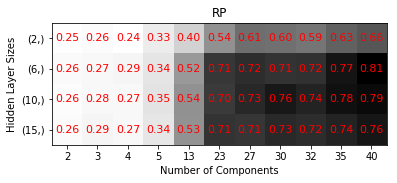

Seed = 1


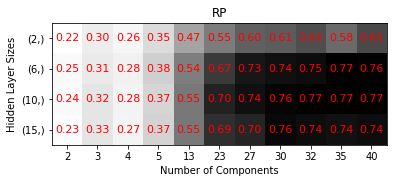

Seed = 2


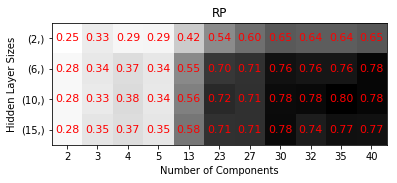

In [23]:
x_variable = f"param_{dim_red_name}__n_components"
y_variable = f"param_mlp__hidden_layer_sizes"
z_variable = "mean_test_score"

for seed in seeds:
    print(f"Seed = {seed}")
    df_to_heatmap(sweep_results[seed]['results'], x_variable, y_variable, z_variable, fontsize=11, xlabel='Number of Components', ylabel='Hidden Layer Sizes', title=f'{dim_red_name.upper()}', savefig=f'{casename}_gs_{seed}.png')
    plt.show()

[0.792  0.9655 0.951  1.0795 1.6715 2.142  2.181  2.2955 2.288  2.3425
 2.363 ]


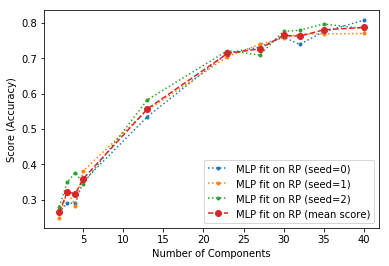

In [24]:
x_variable = f"param_{dim_red_name}__n_components"
z_variable = "mean_test_score"
fig, ax = plt.subplots()
len_x = len(sweep_results[0]['results'].loc[:, x_variable].unique())
mean_scores = np.zeros(len_x)
for seed in seeds:
    best_scores = get_max_along_df_axis(sweep_results[seed]['results'], z_variable, x_variable)
    mean_scores += best_scores[:, 1]
    ax.plot(best_scores[:, 0], best_scores[:, 1], '.:', label=f'MLP fit on {dim_red_name.upper()} (seed={seed})')
print(mean_scores)
mean_scores /= len(seeds)
ax.plot(best_scores[:, 0], mean_scores, 'o--', label=f'MLP fit on {dim_red_name.upper()} (mean score)')

ax.set_xlabel("Number of Components")
ax.set_ylabel("Score (Accuracy)")
ax.legend()
fig.savefig(f'{casename}_random_summary.png')
plt.show()